# 机器学习练习 5 - 偏差和方差(bias and variance)
主要思想：先简单根据需求实现一个算法模型，之后画出学习曲线，根据曲线判断是 bias 问题还是 variance 问题，再做出具体的解决措施去优化算法模型


set 分为 train set , cv set and test set

In [26]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
def load_data():
    d = sio.loadmat('ex5data1.mat')
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])

'''
X , y ==> training set
Xval, yval ==> cross validation set 交叉验证集
Xtest, ytest ==> test set
'''
X, y, Xval, yval, Xtest, ytest = load_data()
print(X, y, Xval, yval, Xtest, ytest)
X.shape, Xval.shape, yval.shape

[-15.93675813 -29.15297922  36.18954863  37.49218733 -48.05882945
  -8.94145794  15.30779289 -34.70626581   1.38915437 -44.38375985
   7.01350208  22.76274892] [ 2.13431051  1.17325668 34.35910918 36.83795516  2.80896507  2.12107248
 14.71026831  2.61418439  3.74017167  3.73169131  7.62765885 22.7524283 ] [-16.74653578 -14.57747075  34.51575866 -47.01007574  36.97511905
 -40.68611002  -4.47201098  26.53363489 -42.7976831   25.37409938
 -31.10955398  27.31176864  -3.26386201  -1.81827649 -40.7196624
 -50.01324365 -17.41177155   3.5881937    7.08548026  46.28236902
  14.61228909] [ 4.17020201e+00  4.06726280e+00  3.18730676e+01  1.06236562e+01
  3.18360213e+01  4.95936972e+00  4.45159880e+00  2.22763185e+01
 -4.38738274e-05  2.05038016e+01  3.85834476e+00  1.93650529e+01
  4.88376281e+00  1.10971588e+01  7.46170827e+00  1.47693464e+00
  2.71916388e+00  1.09269007e+01  8.34871235e+00  5.27819280e+01
  1.33573396e+01] [-33.31800399 -37.91216403 -51.20693795  -6.13259585  21.26118327
 -40.3

((12,), (21,), (21,))

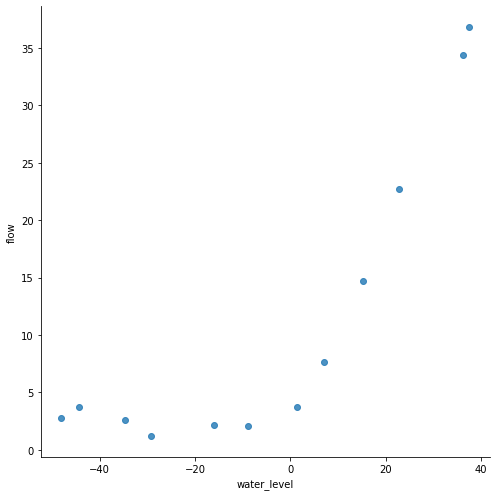

In [28]:
df = pd.DataFrame({'water_level':X, 'flow':y})

sns.lmplot(x='water_level', y='flow', data=df, fit_reg=False, height=7)
plt.show()

In [29]:
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]
print(X, Xval, Xtest)
X.shape, Xval.shape, Xtest.shape

[[  1.         -15.93675813]
 [  1.         -29.15297922]
 [  1.          36.18954863]
 [  1.          37.49218733]
 [  1.         -48.05882945]
 [  1.          -8.94145794]
 [  1.          15.30779289]
 [  1.         -34.70626581]
 [  1.           1.38915437]
 [  1.         -44.38375985]
 [  1.           7.01350208]
 [  1.          22.76274892]] [[  1.         -16.74653578]
 [  1.         -14.57747075]
 [  1.          34.51575866]
 [  1.         -47.01007574]
 [  1.          36.97511905]
 [  1.         -40.68611002]
 [  1.          -4.47201098]
 [  1.          26.53363489]
 [  1.         -42.7976831 ]
 [  1.          25.37409938]
 [  1.         -31.10955398]
 [  1.          27.31176864]
 [  1.          -3.26386201]
 [  1.          -1.81827649]
 [  1.         -40.7196624 ]
 [  1.         -50.01324365]
 [  1.         -17.41177155]
 [  1.           3.5881937 ]
 [  1.           7.08548026]
 [  1.          46.28236902]
 [  1.          14.61228909]] [[  1.         -33.31800399]
 [  1.      

((12, 2), (21, 2), (21, 2))

# 代价函数
<img style="float: left;" src="../img/linear_cost.png">

In [30]:
def cost(theta, X, y):
    '''
    X: R(m*n), m records and n features
    y: R(m)
    theta: R(n), linear regression parameters
    '''
    m = X.shape[0]
    
    inner = X @ theta - y # R(m)
    
    ''' 
    1*m @ m*1 = 1*1 in matrix multiplication
    but you know numpy didn't do transpose in 1d array, so here is just a
    vector inner product to itselves
    '''
    square_sum = inner.T @ inner
    return square_sum / (2 * m)
theta = np.ones(X.shape[1])
cost(theta, X, y)

303.9515255535976

# 梯度
<img style="float: left;" src="../img/linear_gradient.png">

In [31]:
def gradient(theta, X, y):
    m = X.shape[0]
    
    inner = X.T @ (X @ theta - y) # (n,m) @ ((m,n) @ (n,1) - (m,1)) = (n,1)
    
    return inner / m
gradient(theta, X, y)

array([-15.30301567, 598.16741084])

# 正则化梯度
<img style="float: left;" src="../img/linear_reg_gradient.png">

In [32]:
def regularized_gradient(theta, X, y, learning_rate=1):
    m = X.shape[0]
    
    regularized_theta = theta.copy()
    regularized_theta[0] = 0 # for j = 0
    
    regularized_theta = (learning_rate / m) * regularized_theta
    
    return gradient(theta, X, y) + regularized_theta

regularized_gradient(theta, X, y)

array([-15.30301567, 598.25074417])

# 拟合数据
> 正则化项 $\lambda=1$

# 正则化代价函数
$$J\left( \theta  \right)=\frac{1}{2m}\sum\limits_{i=1}^{m}{{{\left( {{h}_{\theta }}\left( {{x}^{(i)}} \right)-{{y}^{(i)}} \right)}^{2}}}+\frac{\lambda }{2m}\sum\limits_{j=1}^{n}{\theta _{j}^{2}}$$

In [40]:
def regularized_cost(theta, X, y, learning_rate=1):
    m = X.shape[0]
    
    regularized_term = (learning_rate / (2 * m)) * np.power(theta[1:], 2).sum()
    
    return cost(theta, X, y) + regularized_term

In [43]:
def linear_regression(X, y, learning_rate=1):
    """linear regression
    args:
        X: feature matrix, (m, n+1)  with incercept x0=1 ==> 偏置项
        y: target vector, (m, )
        l: lambda constant for regularization

    return: trained parameters
    """
    
    # init theta 
    theta = np.ones(X.shape[1])
    
    # train the modle
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, learning_rate),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True})
    return res
final_theta = linear_regression(X, y, learning_rate=0).get('x')
final_theta

array([13.08790362,  0.36777923])

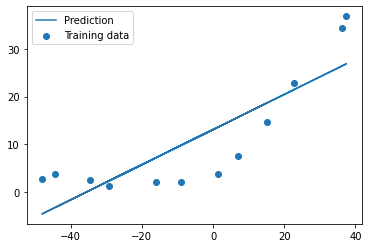

In [35]:
b = final_theta[0] # intercept
m = final_theta[1] # slope

plt.scatter(X[:,1], y, label="Training data")
plt.plot(X[:, 1], X[:, 1]*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

# 学习曲线

1.使用训练集的子集来拟合应模型

2.在计算训练代价和交叉验证代价时，没有用正则化

3.记住使用相同的训练集子集来计算训练代价

In [44]:
training_cost, cv_cost = [], []
m = X.shape[0]
for i in range(1, m+1):
    res = linear_regression(X[:i, :], y[:i], learning_rate=0)
    
    tc = regularized_cost(res.x, X[:i, :], y[:i], learning_rate=0)
    cv = regularized_cost(res.x, Xval, yval, learning_rate=0)
    
    training_cost.append(tc)
    cv_cost.append(cv)

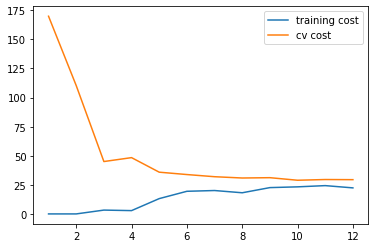

In [45]:
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend(loc=1)
plt.show()

>这个模型拟合不太好, **欠拟合了**，因为有较高的 error ，且 cv cost 约等于 training cost


>The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias)

# 解决方案：增加多项式特征
when a training set **X** of size m x 1 is passed into the function, the function should return a m × p matrix **X_poly**,where column 1 holds the original values of **X**, column 2 holds the values of **X^2**, column 3 holds the values of **X^3**, and so on.

In [50]:
def poly_features(x, power, as_ndarray=False):
    data = {'f{}'.format(i) : np.power(x, i) for i in range(1, power+1)} # x, x^2, x^3...
    df = pd.DataFrame(data)

    return df.as_matrix() if as_ndarray else df

In [52]:
X, y, Xval, yval, Xtest, ytest = load_data()
poly_features(X, power=3)

,f1,f2
0,-15.936758,253.980260
1,-29.152979,849.896197
2,36.189549,1309.683430
3,37.492187,1405.664111
4,-48.058829,2309.651088
5,-8.941458,79.949670
6,15.307793,234.328523
7,-34.706266,1204.524887
8,1.389154,1.929750
9,-44.383760,1969.918139


In [53]:
def feature_scaling(df): 
    '''
    特征缩放，目的是为了让 features 的值尽可能小
    aim to make gradient faster
    '''
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [58]:
def prepare_poly_data(*args, power):
    """
    args: keep feeding in X, Xval, or Xtest
        will return in the same order
    """
    def prepare(x):
        # expand feature
        df = poly_features(x, power=power)
        
        # feature_scaling
        ndarr = feature_scaling(df).values
        
         # add intercept term
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)
    
    return [prepare(x) for x in args]

# prepare for the ploynomial data for 8, or any order you want

In [59]:
X_poly, Xval_poly, Xtest_poly= prepare_poly_data(X, Xval, Xtest, power=8)
X_poly[:3, :]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01]])

# 画出学习曲线
> 首先，我们没有使用正则化，所以 $\lambda=0$

In [68]:
def plot_learning_curve(X, y, Xval, yval, l=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]

    for i in range(1, m + 1):
        # regularization applies here for fitting parameters
        res = linear_regression(X[:i, :], y[:i], l)

        # remember, when you compute the cost here, you are computing
        # non-regularized cost. Regularization is used to fit parameters only
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)

        training_cost.append(tc)
        cv_cost.append(cv)

    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    plt.legend(loc=1)


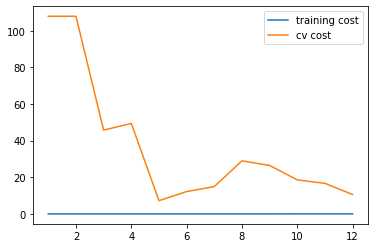

In [69]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=0)
plt.show()

training error is low, but the cross validation error is high. There is a gap between the training and cross validation errors, indicating a high variance problem.

training error 和 cv error 相差过大，是一个**过拟合**问题

# try 正则化 $\lambda=1$
One way to combat the overfitting (high-variance) problem is to add regularization to the model. 

增加正则化

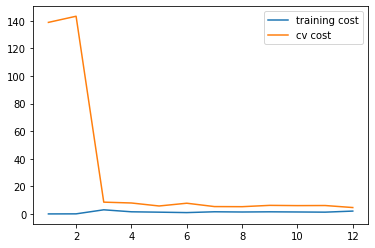

In [70]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=1)
plt.show()

>training error 和 cv error 接近了一些，证明模型变好了一点，减轻了**过拟合**

>This shows
the λ = 1 regularized polynomial regression model does not have the high-
bias or high-variance problems. In effect, it achieves a good trade-off between
bias and variance.

# try $\lambda=100$

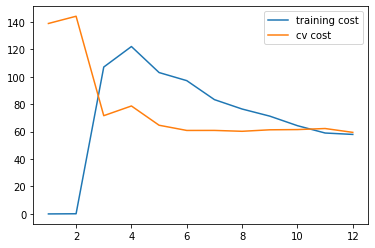

In [71]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=100)
plt.show()

For λ = 100, you should see a polynomial fit (Figure 8) that does not
follow the data well. In this case, there is too much regularization and the
model is unable to fit the training data

**欠拟合**

# Selecting λ using a cross validation set

In [72]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

In [74]:
for l in l_candidate:
    res = linear_regression(X_poly, y, l)
    
    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)
    
    training_cost.append(tc)
    cv_cost.append(cv)

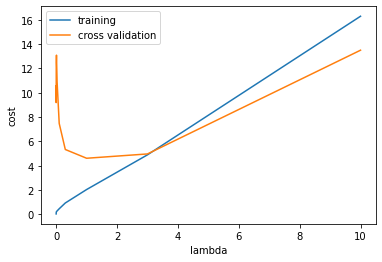

In [75]:
plt.plot(l_candidate, training_cost, label='training')
plt.plot(l_candidate, cv_cost, label='cross validation')
plt.legend(loc=2)

plt.xlabel('lambda')

plt.ylabel('cost')
plt.show()

In [79]:
# best cv I got from all those candidates
best_lambda = l_candidate[np.argmin(cv_cost)] # agrmin(func) --> 使 func 取最小值时的下标

1

>用 cv set 运行时，$\lambda = 1$ 是最优选择，这个时候测试代价最小

In [81]:
# use test data to compute the cost
for l in l_candidate:
    theta = linear_regression(X_poly, y, l).x
    print('test cost(l={}) = {}'.format(l, cost(theta, Xtest_poly, ytest)))

test cost(l=0) = 10.395630614070194
test cost(l=0.001) = 10.958142754029065
test cost(l=0.003) = 11.01926725339099
test cost(l=0.01) = 10.638342512012924
test cost(l=0.03) = 9.831642588195937
test cost(l=0.1) = 8.45179541387166
test cost(l=0.3) = 7.243057897292717
test cost(l=1) = 7.5260461148867615
test cost(l=3) = 11.834866917505687
test cost(l=10) = 28.089516090810797


>用 test set 运行时，$\lambda = 0.3$ 是最优选择，这个时候测试代价最小